Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split= 0.2 , subset= 'training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(180,
    180), shuffle=True, seed=123, validation_split= 0.2 , subset= 'validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# lets iterate through first 5 batches of dataset
for images, labels in train_ds.take(5):
  unique_li = []
  unique_images = []
  # make a list of all unique images from each class
  for i in range(32):
    if class_names[labels[i]] not in unique_li:
      unique_li.append(class_names[labels[i]])
      unique_images.append((class_names[labels[i]],images[i]))
  # Check if images from all class are covered, if so then we dont need to check next batch, hence we can break the loop
  if len(unique_images)==9:
    print("Found",len(unique_images),"classes in batch")
    break

Found 9 classes in batch


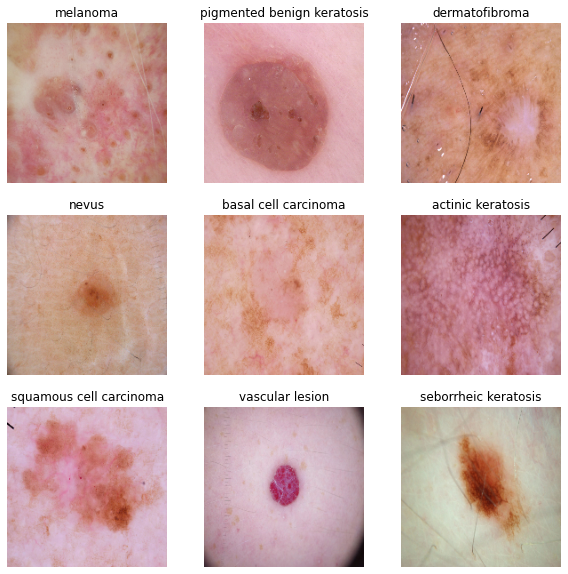

In [11]:
# plot image from unique images list
plt.figure(figsize=(10, 10))
# iterate through all unique images from each class and display using matplotlib
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(unique_images[i][1].numpy().astype("uint8"))
  plt.title(unique_images[i][0])
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
#creating variale for number of classes
num_classes = len(class_names)

In [14]:
img_size = 180
# Build Normalization layer by rescaling between 0-1, lets also specify input shape with 180x180x3 as we will be using this in all future layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))
# Lets build sequential model with 3 conv layers with 16,32,64 filters, 3 max pooling , then flatten the layer , build a dense layer of 128 and conclude with softmax function layer for output 
model = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# Resizing the image to 180x180
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing (Resizing)         (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 149s 681ms/step - loss: 2.0916 - accuracy: 0.2093 - val_loss: 1.9620 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7984 - accuracy: 0.3387 - val_loss: 1.6731 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5299 - accuracy: 0.4704 - val_loss: 1.4524 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4120 - accuracy: 0.4978 - val_loss: 1.4854 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3195 - accuracy: 0.5458 - val_loss: 1.4683 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2564 - accuracy: 0.5508 - val_loss: 1.3919 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2053 - accuracy: 0.5765 - val_loss: 1.4819 - val_accuracy: 0.5369
Epoch 8/20
56/56 [===

### Visualizing training results

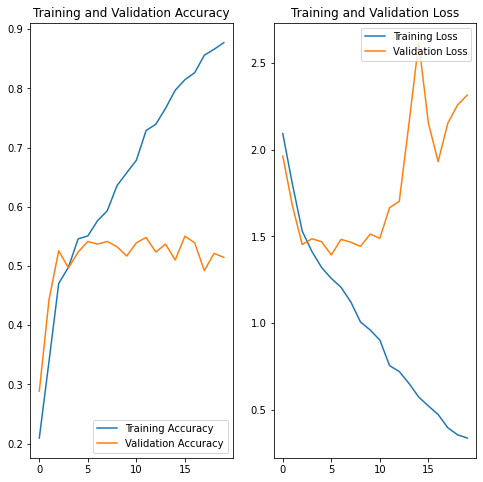

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#creating dataframe which will contain details about modl performance
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.877232,0.514541,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observation** :
*   The training accuracy at the end we got is 87% and validation accuracy is 51%. 
*   Since there is huge gap between training and validation accuracy, the model will not perform well on unseen dataset.
*   As we can see from the plot that as the number of epochs increases, the training accuracy also increased but the validation accuracy reduced. This is clear case of overfitting.
*   We can also see that training loss decreased and validation loss increased with the number of epochs.

In [20]:
# Choosing an appropriate data augumentation strategy. 
# Lets build a layer which performs just the random rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

(-0.5, 179.5, 179.5, -0.5)

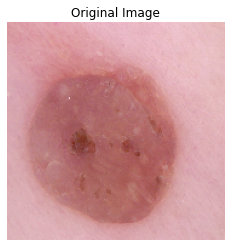

In [21]:
# Visualize how your augmentation strategy works for one instance of training image.
# Pick one of the image from the unique images list
import random
image = tf.expand_dims(unique_images[random.randint(0,8)][1], 0)
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

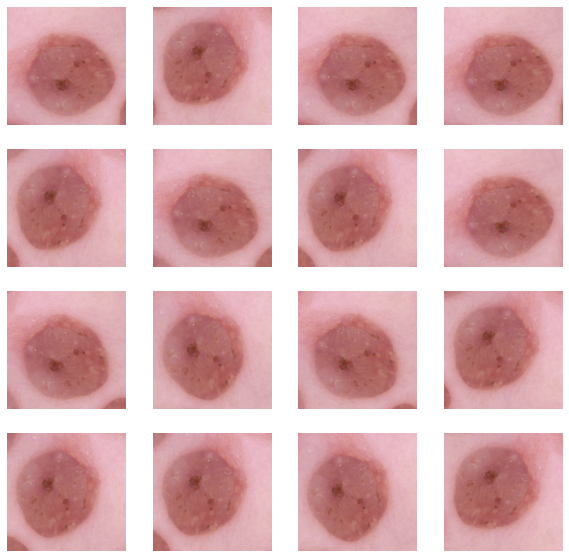

In [22]:
# Passing through the data augmentation layers and display the image to visualize how data is getting augmented 
augmented_image = data_augmentation(image)
plt.figure(figsize=(10, 10))
for i in range(16):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

## Observation
We can see that slight rotations are applied to the images using the data augmentation layer with probablity of 0.2

### Creating the model, compiling and training the model


In [23]:
img_size = 180
# Build the sequential layers same as before with an extra data augmentation layer
model_augm1 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# resizing the layer
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [24]:
model_augm1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_augm1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [25]:
#Training the model for 20 epochs
history = model_augm1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 4s 50ms/step - loss: 2.0372 - accuracy: 0.2539 - val_loss: 1.8268 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6251 - accuracy: 0.4280 - val_loss: 1.5280 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4880 - accuracy: 0.4810 - val_loss: 1.6650 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5070 - accuracy: 0.4593 - val_loss: 1.5428 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3845 - accuracy: 0.4961 - val_loss: 1.4355 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3239 - accuracy: 0.5273 - val_loss: 1.5568 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2954 - accuracy: 0.5430 - val_loss: 1.3204 - val_accuracy: 0.5280
Epoch 8/20
56/56 [======

### Visualizing the results

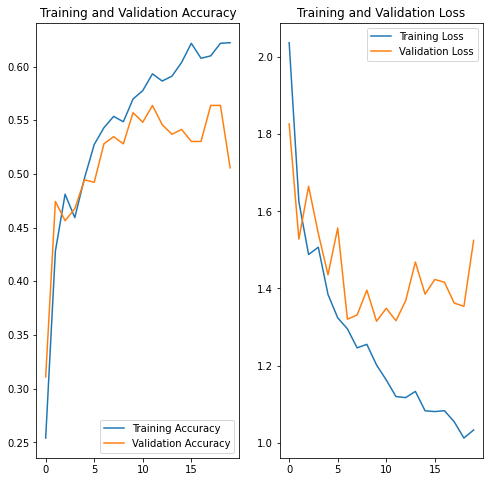

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
accuracy_history_df = accuracy_history_df.append([{"Type":"Data Augmentation","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.877232,0.514541,20
0,Data Augmentation,0.622210,0.505593,20


## **Observation**
We can see that training accuracy has reduced and validation accuracy have improved a little are but they are close to each other now
but we see that our model is underfitting as the training accuracy is low

In [28]:
# lets train by adding a dropout of 0.25
model_dropout = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [29]:
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 resizing_2 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [30]:
history_dropout = model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 4s 49ms/step - loss: 1.9000 - accuracy: 0.3052 - val_loss: 1.6944 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 1.6229 - accuracy: 0.4068 - val_loss: 1.5839 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.5654 - accuracy: 0.4342 - val_loss: 1.5389 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.5116 - accuracy: 0.4515 - val_loss: 1.5370 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4498 - accuracy: 0.4810 - val_loss: 1.4011 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3727 - accuracy: 0.5140 - val_loss: 1.3759 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1.3400 - accuracy: 0.5391 - val_loss: 1.3626 - val_accuracy: 0.5414
Epoch 8/20
56/56 [======

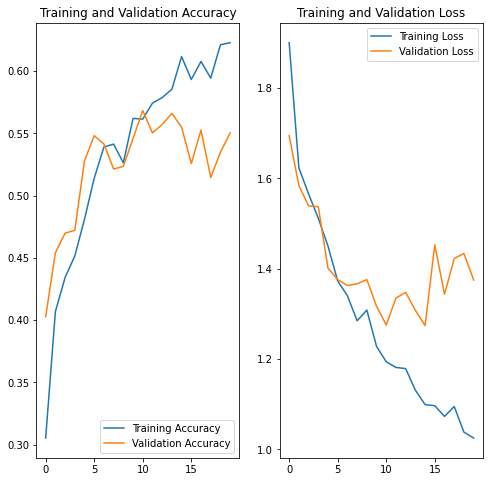

In [31]:
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy']

loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
accuracy_history_df = accuracy_history_df.append([{"Type":"Dropout","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.877232,0.514541,20
0,Data Augmentation,0.622210,0.505593,20
0,Dropout,0.622768,0.550336,20


### **Observation**

*   We can see that accuracy of training and validation did not have much affect after adding dropout layer, although making validation accuracy a bit closer to training.
*   We see that model is still underfitting. Lets keep the dropout layer, just to add some regularization layer if there is some overfitting in future




#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [1]:
class_distr={}
# Go through all training dataset batches
for image_batch, labels_batch in train_ds:
  # prepare the count of images in each class
    for i in range(image_batch.shape[0]):
      if class_names[labels_batch[i]] in class_distr:
        class_distr[class_names[labels_batch[i]]]+=1
      else:
        class_distr[class_names[labels_batch[i]]]=1
# Display the distribution
class_distr

NameError: name 'train_ds' is not defined

In [34]:
# Lets prepare the class distribution Dataframe
df_sample_distr = pd.DataFrame({"Class Name":class_distr.keys(), "Samples":class_distr.values()})
df_sample_distr.sort_values('Samples',ascending=False)

,Class Name,Samples
2,pigmented benign keratosis,370
1,melanoma,352
7,basal cell carcinoma,309
3,nevus,277
0,squamous cell carcinoma,142
8,vascular lesion,115
4,actinic keratosis,92
6,dermatofibroma,77
5,seborrheic keratosis,58


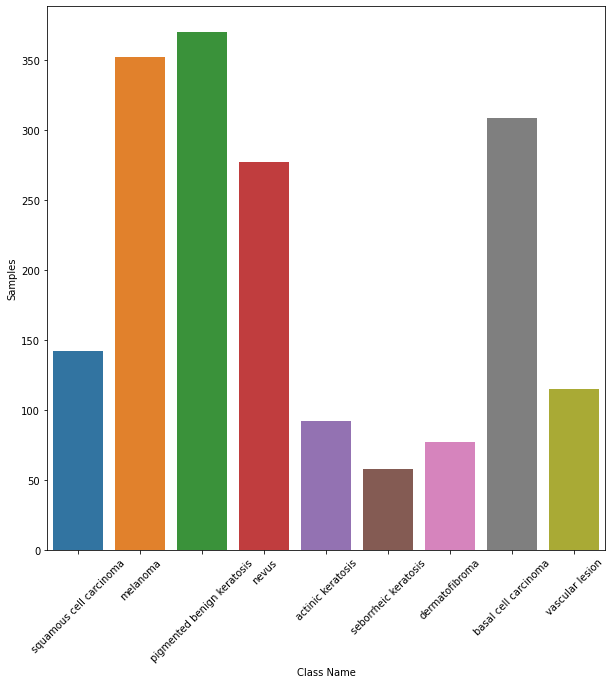

In [35]:
# Lets visualize Class Distribution
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(data=df_sample_distr,x='Class Name',y='Samples')
plt.xticks(rotation = 45) 
plt.show()

#### Findings: 
#### - Which class has the least number of samples?
Answer: seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Answer: pigmented benign keratosis

#### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset= "/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE3DA148210>: 100%|██████████| 500/500 [00:26<00:00, 18.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE450090710>: 100%|██████████| 500/500 [00:27<00:00, 17.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE450169F90>: 100%|██████████| 500/500 [00:29<00:00, 17.13 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE3DA1C5250>: 100%|██████████| 500/500 [01:52<00:00,  4.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE3DA122990>: 100%|██████████| 500/500 [01:40<00:00,  4.96 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3DA2D9D10>: 100%|██████████| 500/500 [00:25<00:00, 19.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE3DA1C8A10>: 100%|██████████| 500/500 [00:52<00:00,  9.50 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3DA0FF450>: 100%|██████████| 500/500 [00:23<00:00, 20.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE3DA280090>: 100%|██████████| 500/500 [00:24<00:00, 20.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob

In [40]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024515.jpg_67dc60af-18b8-4c6d-8f01-1c55b8a6c1fb.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025467.jpg_4988f5ec-e947-43da-8f7c-90a1d29aadf2.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028113.jpg_a47db7ac-a8d7-463b-a5bf-2e83a9849e47.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026213.jpg_25b33699-018d-4217-a049-1fac894ea470.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Col

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma


In [44]:
df2['Label'].value_counts()

actinic keratosis             500
dermatofibroma                500
pigmented benign keratosis    500
vascular lesion               500
basal cell carcinoma          500
melanoma                      500
nevus                         500
seborrheic keratosis          500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [45]:
# Lets prepare a dataframe containing paths to original images present outside of output folder, 
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("one of the path to original dataset image",path_list[0])
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("lesion of one of the image",lesion_list[0])
dataframe_dict = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print("Shape of original dataset",df1.shape)
df1.head()

one of the path to original dataset image /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024632.jpg
lesion of one of the image basal cell carcinoma
Shape of original dataset (2239, 2)


,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma


In [46]:
# CHeck class distribution again
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [47]:
# Lets merge the original and new augmented images dataframe
new_df = df1.append(df2)
print("Shape of merged dataset",new_df.shape)
new_df.head()

Shape of merged dataset (6739, 2)


,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma


In [48]:
# lets check the final class distribution of the dataset
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

#### Training the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [50]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [52]:
# Lets check the classes again to re confirm if its those 9 classes again
class_names_new = train_ds.class_names
num_classes1 = len(class_names_new)
print("Classes",class_names_new)
print("Number of classes",num_classes1)

Classes ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes 9


#### Creating your model (make sure to include normalization)

In [53]:
## your code goes here
## your code goes here
img_size = 180
# lets build layer with same layer as before
model_augm2 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),# Adding one more layer with 128 to improve the accuracy even more
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### Compiling your model (Choose optimizer and loss function appropriately)

In [54]:
# Compile the model
model_augm2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_augm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 resizing_3 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

#### Training your model

In [55]:
epochs = 50
## Your code goes here, use 50 epochs.
history_augm2 = model_augm2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 65s 367ms/step - loss: 1.8279 - accuracy: 0.2938 - val_loss: 1.6401 - val_accuracy: 0.3957
Epoch 2/50
169/169 [==============================] - 42s 240ms/step - loss: 1.5226 - accuracy: 0.4186 - val_loss: 1.3675 - val_accuracy: 0.4937
Epoch 3/50
169/169 [==============================] - 44s 250ms/step - loss: 1.4149 - accuracy: 0.4527 - val_loss: 1.3663 - val_accuracy: 0.4937
Epoch 4/50
169/169 [==============================] - 40s 231ms/step - loss: 1.3008 - accuracy: 0.5032 - val_loss: 1.2756 - val_accuracy: 0.5338
Epoch 6/50
169/169 [==============================] - 40s 228ms/step - loss: 1.2688 - accuracy: 0.5119 - val_loss: 1.2038 - val_accuracy: 0.5442
Epoch 7/50
169/169 [==============================] - 40s 230ms/step - loss: 1.2107 - accuracy: 0.5358 - val_loss: 1.1314 - val_accuracy: 0.5865
Epoch 8/50
169/169 [==============================] - 40s 231ms/step - loss: 1.1378 - accuracy: 0.5677 - val_loss: 1.1827 - val_accuracy: 0.5

####  Visualizing the model results

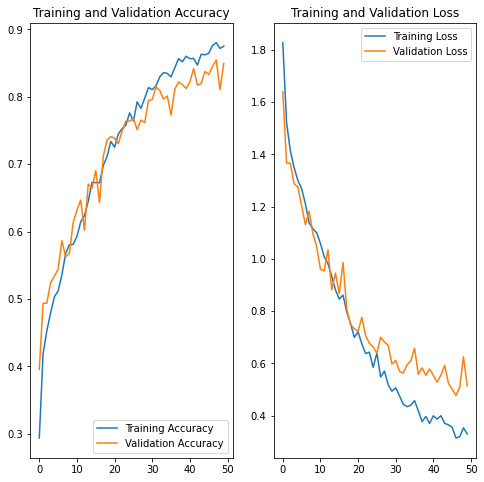

In [56]:
acc = history_augm2.history['accuracy']
val_acc = history_augm2.history['val_accuracy']

loss = history_augm2.history['loss']
val_loss = history_augm2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
accuracy_history_df = accuracy_history_df.append([{"Type":"Class Imbalance","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.877232,0.514541,20
0,Data Augmentation,0.622210,0.505593,20
0,Dropout,0.622768,0.550336,20
0,Class Imbalance,0.875000,0.849295,50


#### Analyzing your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Observation :**
As we can see in the above table, after solving the issue of class imbalance and increasing the number of images with slight alteration using augmentor, the training accuracy has gone up to 87%. Hence we can say the we were able to solve the issue of underfitting.

We can also see that validation accuracy is also 84%, which is very close to training accuracy, hence there is no overfitting.

If we compare with the previous model's accuracy, using class balancing really helped in improving the accuracy.

The model was also evaluated with more data augmentation techniques but the accuracy reduced a lot because of varying differences between images. But it can be rectified by training it for more number of epochs.
